In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nxcals.api.extraction.data.builders import ParameterDataQuery, DataQuery
from pyspark.sql.functions import col, expr, aggregate
from zoneinfo import ZoneInfo
from functools import reduce
from pyspark.sql import functions as F

import pyspark.pandas as ps

import os
os.environ["PYARROW_IGNORE_TIMEZONE"] = '1'

spark.conf.set("spark.sql.parquet.enableNestedColumnVectorizedReader", "true")

#from nxcals.spark_session_builder import get_or_create
#spark = get_or_create("MY_APP")

/cvmfs/sft.cern.ch/lcg/views/LCG_106a_nxcals_pro/x86_64-el9-gcc13-opt/python/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


25/07/17 14:30:08 INFO ContextHandler: Started o.s.j.s.ServletContextHandler@58028dfc{/SQL,null,AVAILABLE,@Spark}
25/07/17 14:30:08 INFO ContextHandler: Started o.s.j.s.ServletContextHandler@6eeaeeeb{/SQL/json,null,AVAILABLE,@Spark}
25/07/17 14:30:08 INFO ContextHandler: Started o.s.j.s.ServletContextHandler@1a47aab6{/SQL/execution,null,AVAILABLE,@Spark}
25/07/17 14:30:08 INFO ContextHandler: Started o.s.j.s.ServletContextHandler@53db0a10{/SQL/execution/json,null,AVAILABLE,@Spark}
25/07/17 14:30:08 INFO ContextHandler: Started o.s.j.s.ServletContextHandler@28a6cd96{/static/sql,null,AVAILABLE,@Spark}


In [13]:
emitt90 = ParameterDataQuery.builder(spark) \
    .system("CMW") \
    .parameterEq("PS.RING.PROC.TOMO_BCW_OP_BURST_12/TomoResult") \
    .timeWindow('2025-05-10 16:00:00.000', '2025-05-13 04:00:00.000') \
    .build()


In [14]:
emitt90.printSchema()

root
 |-- __record_timestamp__: long (nullable = true)
 |-- __record_version__: long (nullable = true)
 |-- acqStamp: long (nullable = true)
 |-- bunchData: struct (nullable = true)
 |    |-- elements: array (nullable = true)
 |    |    |-- element: long (containsNull = true)
 |    |-- dimensions: array (nullable = true)
 |    |    |-- element: integer (containsNull = true)
 |-- bunchDataReconstructed: struct (nullable = true)
 |    |-- elements: array (nullable = true)
 |    |    |-- element: double (containsNull = true)
 |    |-- dimensions: array (nullable = true)
 |    |    |-- element: integer (containsNull = true)
 |-- bunchEnergyReconstructed: struct (nullable = true)
 |    |-- elements: array (nullable = true)
 |    |    |-- element: double (containsNull = true)
 |    |-- dimensions: array (nullable = true)
 |    |    |-- element: integer (containsNull = true)
 |-- bunchProfileAcquired: struct (nullable = true)
 |    |-- elements: array (nullable = true)
 |    |    |-- element:

In [60]:
emitt90.show(5)

+--------------------+------------------+-------------------+---------+----------------------+------------------------+--------------------+-------------------------+-----------+-------------------+-------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------+------------+-------------+-------------+-------------+----------------------+--------------------+--------------------+--------------------+------------------+------------------+------------------+------------------+--------------------+-----+------+--------------+----------+--------------+-----------+------------+-------------+-------+-------------------+----------------+
|__record_timestamp__|__record_version__|           acqStamp|bunchData|bunchDataReconstructed|bunchEnergyReconstructed|bunchProfileAcquired|bunchProfileReconstructed|      class|         cyclestamp|deltaEs|deltaTs|              device|                 dpp|          durationFt|         emi

In [77]:
funds = DataQuery.builder(spark).byVariables() \
    .system('CMW') \
    .startTime('2025-05-10 16:00:00.000').endTime('2025-05-13 04:00:00.000') \
    .variable('CPS:NXCALS_FUNDAMENTAL') \
    .buildDataset()


In [46]:
funds.printSchema()

root
 |-- BASIC_PERIOD_NB: integer (nullable = true)
 |-- BEAM_ID: integer (nullable = true)
 |-- BEAM_LEVEL_NORMAL: boolean (nullable = true)
 |-- BEAM_TO_LHC: boolean (nullable = true)
 |-- BP_DURATION_MS: integer (nullable = true)
 |-- CYCLE_DURATION_MS: integer (nullable = true)
 |-- CYCLE_NB: integer (nullable = true)
 |-- CYCLE_TAG: integer (nullable = true)
 |-- DYN_DEST: string (nullable = true)
 |-- DYN_DEST_EAST: boolean (nullable = true)
 |-- DYN_DEST_FTS: boolean (nullable = true)
 |-- DYN_DEST_TOF: boolean (nullable = true)
 |-- PARTICLE: string (nullable = true)
 |-- PROG_DEST: string (nullable = true)
 |-- PROG_DEST2: string (nullable = true)
 |-- SPS_BATCH_NUMBER: integer (nullable = true)
 |-- SUPERCYCLE_NB: integer (nullable = true)
 |-- USER: string (nullable = true)
 |-- nxcals_timestamp: long (nullable = true)
 |-- __record_version__: long (nullable = true)
 |-- acqC: integer (nullable = true)
 |-- acqStamp: long (nullable = true)
 |-- class: string (nullable = tru

In [78]:
cyclestamps = funds.where("USER = 'TOF'").select("cyclestamp")
cyclestamps.show()

+-------------------+
|         cyclestamp|
+-------------------+
|1746894190300000000|
|1746895741900000000|
|1746895828300000000|
|1746896039500000000|
|1746896357500000000|
|1746896389900000000|
|1746897567100000000|
|1746897815500000000|
|1746901851100000000|
|1746902260300000000|
|1746902308300000000|
|1746902778700000000|
|1746904356700000000|
|1746904463500000000|
|1746905140300000000|
|1746905256700000000|
|1746905721100000000|
|1746906636700000000|
|1746907573900000000|
|1746907775500000000|
+-------------------+
only showing top 20 rows



In [79]:
filtered_emitt90 = emitt90.join(cyclestamps,on="cyclestamp",how="inner")

In [80]:
filtered_emitt90.sort("cyclestamp").show()

+-------------------+--------------------+------------------+-------------------+---------+----------------------+------------------------+--------------------+-------------------------+-----------+-------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------+------------+--------------------+------------------+------------------+------------------+------------------+--------------------+-----+------+--------------+----------+------------+-----------+------------+-------------+-------+-------------------+----------------+
|         cyclestamp|__record_timestamp__|__record_version__|           acqStamp|bunchData|bunchDataReconstructed|bunchEnergyReconstructed|bunchProfileAcquired|bunchProfileReconstructed|      class|deltaEs|deltaTs|              device|                 dpp|          durationFt|         emitt90Perc|            emittRms|failedBunchIdx|lossFunction|             meanDpp|    meanDurationFt|   meanEmit

In [81]:


data = filtered_emitt90.select("cyclestamp","meanEmitt90Perc").toPandas()

In [82]:
data['cyclestamp'] = pd.to_datetime(data['cyclestamp'], utc=True)
data.set_index(data['cyclestamp'].dt.tz_convert(ZoneInfo("Europe/Berlin")), inplace=True, drop=True)
data.sort_index(inplace=True)

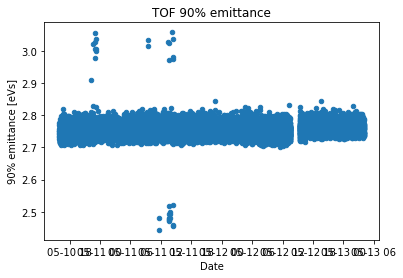

In [83]:
data.plot.scatter(x='cyclestamp',y='meanEmitt90Perc')
plt.xlabel("Date")
plt.ylabel("90% emittance [eVs]")
plt.title("TOF 90% emittance")
plt.show()

In [100]:
length90 = ParameterDataQuery.builder(spark) \
    .system("CMW") \
    .parameterEq("PS.RING.PROC.BUNCH_PROFILES_BCW_OP/BunchLengthData") \
    .timeWindow('2025-05-10 16:00:00.000', '2025-05-13 04:00:00.000') \
    .build()

In [101]:
length90.printSchema()

root
 |-- __record_timestamp__: long (nullable = true)
 |-- __record_version__: long (nullable = true)
 |-- acqCycleTimeMs: struct (nullable = true)
 |    |-- elements: array (nullable = true)
 |    |    |-- element: double (containsNull = true)
 |    |-- dimensions: array (nullable = true)
 |    |    |-- element: integer (containsNull = true)
 |-- acqStamp: long (nullable = true)
 |-- bunch4SigmasFromFwhmNs: struct (nullable = true)
 |    |-- elements: array (nullable = true)
 |    |    |-- element: double (containsNull = true)
 |    |-- dimensions: array (nullable = true)
 |    |    |-- element: integer (containsNull = true)
 |-- bunch4SigmasFromRmsNs: struct (nullable = true)
 |    |-- elements: array (nullable = true)
 |    |    |-- element: double (containsNull = true)
 |    |-- dimensions: array (nullable = true)
 |    |    |-- element: integer (containsNull = true)
 |-- bunch90LeftIdx: struct (nullable = true)
 |    |-- elements: array (nullable = true)
 |    |    |-- element: l

In [102]:
length90= length90.join(cyclestamps,on="cyclestamp",how="inner")

In [110]:
from pyspark.sql.functions import expr

length90 = length90.withColumn("burstArray", length90["burstId.elements"])
length90 = length90.withColumn("bunchLengthArray", length90["meanBunchLengthNs.elements"])


length90 = length90.withColumn(
    "meanBunchLengthForBurst12",
    expr("""
        aggregate(
            filter(
                arrays_zip(burstArray, bunchLengthArray),
                x -> x.burstArray = 12
            ),
            0D,
            (acc, x) -> acc + x.bunchLengthArray
        ) / size(
            filter(
                arrays_zip(burstArray, bunchLengthArray),
                x -> x.burstArray = 12
            )
        )
    """)
)

Row(cyclestamp=1747094400700000000, __record_timestamp__=1747094400700000000, __record_version__=0, acqCycleTimeMs=Row(elements=[170.07431030273438, 170.08314514160156, 170.0919952392578, 170.100830078125, 170.1096649169922, 170.11851501464844, 170.12734985351562, 170.1361846923828, 170.14503479003906, 170.15386962890625, 170.1627197265625, 170.1715545654297, 170.18040466308594, 170.18923950195312, 170.19808959960938, 170.20692443847656, 170.2157745361328, 170.224609375, 170.23345947265625, 170.24229431152344, 170.2511444091797, 170.25997924804688, 170.26882934570312, 170.2776641845703, 170.28651428222656, 170.29534912109375, 170.30419921875, 170.3130340576172, 170.32188415527344, 170.33071899414062, 170.33956909179688, 170.34840393066406, 170.3572540283203, 170.3660888671875, 170.37493896484375, 170.38377380371094, 170.3926239013672, 170.40145874023438, 170.41030883789062, 170.4191436767578, 170.42799377441406, 170.43682861328125, 170.4456787109375, 170.4545135498047, 170.463363647460

In [149]:
data = length90.select('cyclestamp','meanBunchLengthForBurst12').toPandas()

In [114]:
data['cyclestamp'] = pd.to_datetime(data['cyclestamp'], utc=True)
data.set_index(data['cyclestamp'].dt.tz_convert(ZoneInfo("Europe/Berlin")), inplace=True, drop=True)
data.sort_index(inplace=True)


In [148]:
d = data.where(data['meanBunchLengthForBurst12'] > 2)

KeyError: 'meanBunchLengthForBurst12'

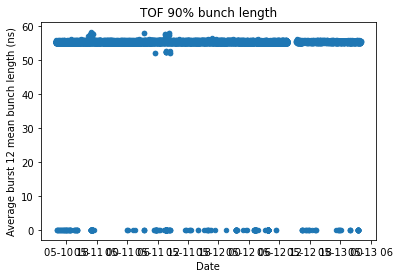

In [143]:
data.plot.scatter(x='cyclestamp',y='meanBunchLengthForBurst12')
plt.xlabel("Date")
plt.ylabel("Average burst 12 mean bunch length (ns)")
plt.title("TOF 90% bunch length")
plt.show()

In [120]:
bunch_or_not = ParameterDataQuery.builder(spark) \
    .system("CMW") \
    .parameterEq("PR.BCT/HotspotIntensity") \
    .timeWindow('2025-05-10 16:00:00.000', '2025-05-13 04:00:00.000') \
    .build()

In [121]:
bunch_or_not.printSchema()

root
 |-- __record_timestamp__: long (nullable = true)
 |-- __record_version__: long (nullable = true)
 |-- acqStamp: long (nullable = true)
 |-- class: string (nullable = true)
 |-- cyclestamp: long (nullable = true)
 |-- dcAftEje1: float (nullable = true)
 |-- dcAftEje2: float (nullable = true)
 |-- dcAftInj1: float (nullable = true)
 |-- dcAftInj2: float (nullable = true)
 |-- dcAftTra: float (nullable = true)
 |-- dcBefEje1: float (nullable = true)
 |-- dcBefEje2: float (nullable = true)
 |-- dcBefInj1: float (nullable = true)
 |-- dcBefInj2: float (nullable = true)
 |-- dcBefTra: float (nullable = true)
 |-- device: string (nullable = true)
 |-- property: string (nullable = true)
 |-- selector: string (nullable = true)
 |-- timeDcAftEje1: integer (nullable = true)
 |-- timeDcAftEje2: integer (nullable = true)
 |-- timeDcAftInj1: integer (nullable = true)
 |-- timeDcAftInj2: integer (nullable = true)
 |-- timeDcAftTra: integer (nullable = true)
 |-- timeDcBefEje1: integer (nullable

In [150]:
data.printSchema()

AttributeError: 'DataFrame' object has no attribute 'printSchema'

In [157]:
data = length90.select('cyclestamp','meanBunchLengthForBurst12')
b = bunch_or_not.select("cyclestamp", "dcAftInj1")
dat = data.where(data['meanBunchLengthForBurst12'] == 0)
b = b.join(dat, on='cyclestamp', how='inner')

b.show()

+-------------------+------------+-------------------------+
|         cyclestamp|   dcAftInj1|meanBunchLengthForBurst12|
+-------------------+------------+-------------------------+
|1747095072700000000|-0.108421296|                      0.0|
|1747101091900000000| -0.05941732|                      0.0|
|1747101264700000000| -0.04349103|                      0.0|
|1747101361900000000|-0.031240035|                      0.0|
|1747101610300000000| -0.06921812|                      0.0|
|1747106687500000000|-0.007963146|                      0.0|
|1747106693500000000| -0.09188246|                      0.0|
|1747106707900000000| -0.06125497|                      0.0|
|1747106716300000000| -0.04594123|                      0.0|
|1747106718700000000| 0.024501987|                      0.0|
|1747106722300000000| -0.09065735|                      0.0|
|1747106730700000000|-0.067993015|                      0.0|
|1747106736700000000| -0.07105576|                      0.0|
|1747106751100000000| -0

In [153]:
no_length = length90.where(length90['meanBunchLengthForBurst12'] < 2)

In [154]:
bun= b.join(no_length, on="cyclestamp", how="inner")

In [155]:
bun = bun.select('cyclestamp', "meanBunchLengthForBurst12","dcAftInj1")

In [142]:
from pyspark.sql.functions import mean

mean_lt_5 = bun.filter(col("meanBunchLengthForBurst12") < 5) \
               .agg(mean("dcAftInj1").alias("mean_dc_lt_5")) \
               .collect()[0]["mean_dc_lt_5"]

mean_gte_5 = bun.filter(col("meanBunchLengthForBurst12") >= 5) \
                .agg(mean("dcAftInj1").alias("mean_dc_gte_5")) \
                .collect()[0]["mean_dc_gte_5"]

print("Mean dcAftInj1 for meanBunchLengthForBurst12 < 5:", mean_lt_5)
print("Mean dcAftInj1 for meanBunchLengthForBurst12 ≥ 5:", mean_gte_5)

Mean dcAftInj1 for meanBunchLengthForBurst12 < 5: 2.3455716782687372
Mean dcAftInj1 for meanBunchLengthForBurst12 ≥ 5: None


In [2]:
vdc11 = ParameterDataQuery.builder(spark) \
    .system("CMW") \
    .parameterEq("PA.VDC11-SA/CycleSamples") \
    .timeWindow('2025-05-10 16:00:00.000', '2025-05-13 04:00:00.000') \
    .build()

vdc36 = ParameterDataQuery.builder(spark) \
    .system("CMW") \
    .parameterEq("PA.VDC36-SA/CycleSamples") \
    .timeWindow('2025-05-10 16:00:00.000', '2025-05-13 04:00:00.000') \
    .build()

vdc46 = ParameterDataQuery.builder(spark) \
    .system("CMW") \
    .parameterEq("PA.VDC46-SA/CycleSamples") \
    .timeWindow('2025-05-10 16:00:00.000', '2025-05-13 04:00:00.000') \
    .build()

vdc51 = ParameterDataQuery.builder(spark) \
    .system("CMW") \
    .parameterEq("PA.VDC51-SA/CycleSamples") \
    .timeWindow('2025-05-10 16:00:00.000', '2025-05-13 04:00:00.000') \
    .build()

vdc56 = ParameterDataQuery.builder(spark) \
    .system("CMW") \
    .parameterEq("PA.VDC56-SA/CycleSamples") \
    .timeWindow('2025-05-10 16:00:00.000', '2025-05-13 04:00:00.000') \
    .build()

vdc66 = ParameterDataQuery.builder(spark) \
    .system("CMW") \
    .parameterEq("PA.VDC66-SA/CycleSamples") \
    .timeWindow('2025-05-10 16:00:00.000', '2025-05-13 04:00:00.000') \
    .build()

vdc76 = ParameterDataQuery.builder(spark) \
    .system("CMW") \
    .parameterEq("PA.VDC76-SA/CycleSamples") \
    .timeWindow('2025-05-10 16:00:00.000', '2025-05-13 04:00:00.000') \
    .build()

vdc81 = ParameterDataQuery.builder(spark) \
    .system("CMW") \
    .parameterEq("PA.VDC81-SA/CycleSamples") \
    .timeWindow('2025-05-10 16:00:00.000', '2025-05-13 04:00:00.000') \
    .build()

vdc86 = ParameterDataQuery.builder(spark) \
    .system("CMW") \
    .parameterEq("PA.VDC86-SA/CycleSamples") \
    .timeWindow('2025-05-10 16:00:00.000', '2025-05-13 04:00:00.000') \
    .build()

vdc91 = ParameterDataQuery.builder(spark) \
    .system("CMW") \
    .parameterEq("PA.VDC91-SA/CycleSamples") \
    .timeWindow('2025-05-10 16:00:00.000', '2025-05-13 04:00:00.000') \
    .build()

vdc96 = ParameterDataQuery.builder(spark) \
    .system("CMW") \
    .parameterEq("PA.VDC96-SA/CycleSamples") \
    .timeWindow('2025-05-10 16:00:00.000', '2025-05-13 04:00:00.000') \
    .build()

25/07/14 15:08:01 INFO ContextHandler: Started o.s.j.s.ServletContextHandler@1a8ac6dd{/SQL,null,AVAILABLE,@Spark}
25/07/14 15:08:01 INFO ContextHandler: Started o.s.j.s.ServletContextHandler@5534335e{/SQL/json,null,AVAILABLE,@Spark}
25/07/14 15:08:01 INFO ContextHandler: Started o.s.j.s.ServletContextHandler@7ac4109b{/SQL/execution,null,AVAILABLE,@Spark}
25/07/14 15:08:01 INFO ContextHandler: Started o.s.j.s.ServletContextHandler@1b6c2343{/SQL/execution/json,null,AVAILABLE,@Spark}
25/07/14 15:08:01 INFO ContextHandler: Started o.s.j.s.ServletContextHandler@146fcf6f{/static/sql,null,AVAILABLE,@Spark}


In [5]:
vdcs = [vdc11, vdc36, vdc46, vdc51, vdc56, vdc66, vdc76, vdc81, vdc86, vdc91, vdc96]

for vdc in vdcs:
    vdc = filter_user(vdc,'TOF', '2025-05-10 16:00:00.000', '2025-05-13 04:00:00.000')
    vdc = vdc.select('cyclestamp','samples')

    
ren_vdcs = [vdc.withColumnRenamed("samples",f"samples_{i}").withColumn(f"samples_{i}", col(f"samples_{i}.elements")) for i,vdc in enumerate(vdcs)]

joined_vdcs = reduce(lambda left, right: left.join(right, on='cyclestamp'), ren_vdcs)

vec_cols = [f"samples_{i}" for i in range(len(vdcs))]

sum_expr = f"""
    transform(
        arrays_zip({','.join(vec_cols)}),
        x -> {" + ".join(f"x.{c}" for c in vec_cols)}   
    )
"""

result_vdcs = joined_vdcs.select("cyclestamp", expr(sum_expr).alias("sum_samples"))


'''
vdc11 = filter_user(vdc11,'TOF', '2025-05-10 16:00:00.000', '2025-05-13 04:00:00.000')
vdc36 = filter_user(vdc36,'TOF', '2025-05-10 16:00:00.000', '2025-05-13 04:00:00.000')
vdc46 = filter_user(vdc46,'TOF', '2025-05-10 16:00:00.000', '2025-05-13 04:00:00.000')
vdc51 = filter_user(vdc51,'TOF', '2025-05-10 16:00:00.000', '2025-05-13 04:00:00.000')
vdc56 = filter_user(vdc56,'TOF', '2025-05-10 16:00:00.000', '2025-05-13 04:00:00.000')
vdc66 = filter_user(vdc66,'TOF', '2025-05-10 16:00:00.000', '2025-05-13 04:00:00.000')
vdc76 = filter_user(vdc76,'TOF', '2025-05-10 16:00:00.000', '2025-05-13 04:00:00.000')
vdc81 = filter_user(vdc81,'TOF', '2025-05-10 16:00:00.000', '2025-05-13 04:00:00.000')
vdc86 = filter_user(vdc86,'TOF', '2025-05-10 16:00:00.000', '2025-05-13 04:00:00.000')
vdc91 = filter_user(vdc91,'TOF', '2025-05-10 16:00:00.000', '2025-05-13 04:00:00.000')
vdc96 = filter_user(vdc96,'TOF', '2025-05-10 16:00:00.000', '2025-05-13 04:00:00.000')
'''

25/07/14 15:09:16 WARN CheckAllocator: More than one DefaultAllocationManager on classpath. Choosing first found


ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/cvmfs/sft.cern.ch/lcg/views/LCG_106a_nxcals_pro/x86_64-el9-gcc13-opt/python/pyspark/sql/pandas/conversion.py", line 280, in _collect_as_arrow
    results = list(batch_stream)
              ^^^^^^^^^^^^^^^^^^
  File "/cvmfs/sft.cern.ch/lcg/views/LCG_106a_nxcals_pro/x86_64-el9-gcc13-opt/python/pyspark/sql/pandas/serializers.py", line 69, in load_stream
    for batch in self.serializer.load_stream(stream):
  File "/cvmfs/sft.cern.ch/lcg/views/LCG_106a_nxcals_pro/x86_64-el9-gcc13-opt/python/pyspark/sql/pandas/serializers.py", line 111, in load_stream
    reader = pa.ipc.open_stream(stream)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/cvmfs/sft.cern.ch/lcg/views/LCG_106a_nxcals_pro/x86_64-el9-gcc13-opt/lib/python3.11/site-packages/pyarrow/ipc.py", line 190, in open_stream
    return RecordBatchStreamReader(source, options=options,
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  

KeyboardInterrupt: 

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/cvmfs/sft.cern.ch/lcg/views/LCG_106a_nxcals_pro/x86_64-el9-gcc13-opt/lib/python3.11/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/cvmfs/sft.cern.ch/lcg/views/LCG_106a_nxcals_pro/x86_64-el9-gcc13-opt/lib/python3.11/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "/cvmfs/sft.cern.ch/lcg/releases/Python/3.11.9-2924c/x86_64-el9-gcc13-opt/lib/python3.11/socket.py", line 706, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


KeyboardInterrupt: 

In [2]:
# helper method that filters df for only desired user by matching cyclestamps
def filter_user(df, user, start_time, end_time):
    
    funds = DataQuery.builder(spark).byVariables() \
        .system('CMW') \
        .startTime(start_time).endTime(end_time) \
        .variable('CPS:NXCALS_FUNDAMENTAL') \
        .buildDataset()
    
    cyclestamps = funds.filter(col("USER") == user).select("cyclestamp")
    
    df = df.join(cyclestamps,on="cyclestamp",how="inner")
    
    return df


# sends cyclestamps to corresponding datetimes
def format_datetime(data):
    data['cyclestamp'] = pd.to_datetime(data['cyclestamp'], utc=True)
    data.set_index(data['cyclestamp'].dt.tz_convert(ZoneInfo("Europe/Berlin")), inplace=True, drop=True)
    data.sort_index(inplace=True)
    return data
    

# get data for each cavity and return as an array
def get_vdcs(start_time, end_time):
    vdc11 = ParameterDataQuery.builder(spark) \
        .system("CMW") \
        .parameterEq("PA.VDC11-SA/CycleSamples") \
        .timeWindow(start_time, end_time) \
        .build()
    vdc36 = ParameterDataQuery.builder(spark) \
        .system("CMW") \
        .parameterEq("PA.VDC36-SA/CycleSamples") \
        .timeWindow(start_time, end_time) \
        .build()
    vdc46 = ParameterDataQuery.builder(spark) \
        .system("CMW") \
        .parameterEq("PA.VDC46-SA/CycleSamples") \
        .timeWindow(start_time, end_time) \
        .build()
    vdc51 = ParameterDataQuery.builder(spark) \
        .system("CMW") \
        .parameterEq("PA.VDC51-SA/CycleSamples") \
        .timeWindow(start_time, end_time) \
        .build()
    vdc56 = ParameterDataQuery.builder(spark) \
        .system("CMW") \
        .parameterEq("PA.VDC56-SA/CycleSamples") \
        .timeWindow(start_time, end_time) \
        .build()
    vdc66 = ParameterDataQuery.builder(spark) \
        .system("CMW") \
        .parameterEq("PA.VDC66-SA/CycleSamples") \
        .timeWindow(start_time, end_time) \
        .build()
    vdc76 = ParameterDataQuery.builder(spark) \
        .system("CMW") \
        .parameterEq("PA.VDC76-SA/CycleSamples") \
        .timeWindow(start_time, end_time) \
        .build()
    vdc81 = ParameterDataQuery.builder(spark) \
        .system("CMW") \
        .parameterEq("PA.VDC81-SA/CycleSamples") \
        .timeWindow(start_time, end_time) \
        .build()
    vdc86 = ParameterDataQuery.builder(spark) \
        .system("CMW") \
        .parameterEq("PA.VDC86-SA/CycleSamples") \
        .timeWindow(start_time, end_time) \
        .build()
    vdc91 = ParameterDataQuery.builder(spark) \
        .system("CMW") \
        .parameterEq("PA.VDC91-SA/CycleSamples") \
        .timeWindow(start_time, end_time) \
        .build()
    vdc96 = ParameterDataQuery.builder(spark) \
        .system("CMW") \
        .parameterEq("PA.VDC96-SA/CycleSamples") \
        .timeWindow(start_time, end_time) \
        .build()

    return [vdc11, vdc36, vdc46, vdc51, vdc56, vdc66, vdc76, vdc81, vdc86, vdc91, vdc96]


# splits the vdc dfs in three based on if the cyclestamps correspond to high, average, or low 90% bunch length values
def split_vdc(vdc, cyclestamps_high, cyclestamps_low):
    high_vdc = vdc.filter(col('cyclestamp').isin(cyclestamps_high))
    low_vdc = vdc.filter(col('cyclestamp').isin(cyclestamps_low))
    avg_vdc = vdc.filter((~col('cyclestamp').isin(cyclestamps_high)) & (~col('cyclestamp').isin(cyclestamps_low)))
    
    return high_vdc, low_vdc, avg_vdc


# sum the vdcs in the array to have a df of cyclestamps and rows of total voltage per sampling instance
def total_vdc(vdcs):
    ren_vdcs = [vdc.withColumnRenamed("samples",f"samples_{i}").withColumn(f"samples_{i}", col(f"samples_{i}.elements")) for i,vdc in enumerate(vdcs)]
    joined_vdcs = reduce(lambda left, right: left.join(right, on='cyclestamp'), ren_vdcs)
    vec_cols = [f"samples_{i}" for i in range(len(vdcs))]
    sum_expr = f"""
        transform(
            arrays_zip({','.join(vec_cols)}),
            x -> {" + ".join(f"x.{c}" for c in vec_cols)}   
        )
    """
    total_vdc = joined_vdcs.select("cyclestamp", expr(sum_expr).alias("samples"))
    
    return total_vdc


def mean_vdc(vdc_df):
    
    vdc_df = vdc_df.toPandas()

# get the df for 90% emittance
def get_90emitt(user, start_time, end_time):
    # import data
    df = ParameterDataQuery.builder(spark) \
        .system("CMW") \
        .parameterEq("PS.RING.PROC.TOMO_BCW_OP_BURST_12/TomoResult") \
        .timeWindow(start_time, end_time) \
        .build()
    
    # get correct user
    df = filter_user(df, user, start_time, end_time)
    
    # to pandas and convert to date
    data = df.select("cyclestamp","meanEmitt90Perc").toPandas()
    
    return data

# get the df for 90% bunch length
def get_bunch90length(user, start_time, end_time):
    # get data
    df = ParameterDataQuery.builder(spark) \
        .system("CMW") \
        .parameterEq("PS.RING.PROC.BUNCH_PROFILES_BCW_OP/BunchLengthData") \
        .timeWindow(start_time, end_time) \
        .build()
    
    # get correct user
    df = filter_user(df, user, start_time, end_time)
    
    # get rows into accessible format
    df = df.withColumn("burstArray", df["burstId.elements"])
    df = df.withColumn("bunchLengthArray", df["meanBunchLengthNs.elements"])
    
    # find burst 12's average of mean bunch lengths
    df = df.withColumn(
        "meanBunchLengthForBurst12",
        expr("""
            aggregate(
                filter(
                    arrays_zip(burstArray, bunchLengthArray),
                    x -> x.burstArray = 12
                ),
                0D,
                (acc, x) -> acc + x.bunchLengthArray
            ) / size(
                filter(
                    arrays_zip(burstArray, bunchLengthArray),
                    x -> x.burstArray = 12
                )
            )
        """)
    )
    
    # convert to pandas and cut out low values corresponding to no beam
    data = df.select('cyclestamp','meanBunchLengthForBurst12').toPandas()
    data = data.where(data['meanBunchLengthForBurst12'] > 2)
     
    return data

In [3]:
# shows plots for 90% emittance, 90% bunch length, and total cavity voltage for a given interval of time
def get_plots(user, start_time, end_time):  
    
    # 90% EMITTANCE
    
    # get data and format dates
    data = get_90emitt(user, start_time, end_time)
    data = format_datetime(data)
    
    # plot
    data.plot.scatter(x='cyclestamp',y='meanEmitt90Perc', s=5, figsize=(12,6))
    plt.xlabel("Date")
    plt.ylabel("90% emittance [eVs]")
    plt.title(user + " 90% emittance")
    plt.gcf().autofmt_xdate()
    plt.show()

    # 90% BUNCH LENGTH
    
    # get data
    data = get_bunch90length(user, start_time, end_time)
    
    # record outliers' cyclestamps for voltage analysis
    mu = data['meanBunchLengthForBurst12'].mean()
    sigma = data['meanBunchLengthForBurst12'].std()
    thresh = 5
    data['z_score'] = (data['meanBunchLengthForBurst12'] - mu) / sigma
    cyclestamps_high = set(data.loc[data['z_score'] > thresh, 'cyclestamp'].tolist())
    cyclestamps_low = set(data.loc[data['z_score'] < -thresh, 'cyclestamp'].tolist())
    
    # format date
    data = format_datetime(data)
    
    # plot
    ax = data.plot.scatter(x='cyclestamp',y='meanBunchLengthForBurst12', s=5, color = 'blue', figsize=(12,6))
    plt.axhline((thresh*sigma+mu), linestyle = '--', label = 'High break', color='red')
    plt.axhline((-thresh*sigma+mu), linestyle = '--', label = 'Low break', color= 'green')
    plt.xlabel("Date")
    plt.gcf().autofmt_xdate()
    plt.ylabel("Average burst 12 mean bunch length (ns)")
    plt.legend()
    plt.title(user + " 90% bunch length")
    plt.show()
    
    # VOLTAGES
    
    # put them in an array to make things easier
    vdcs = get_vdcs(start_time, end_time)

    # get correct user and drop unneeded columns
    vdcs = [filter_user(vdc, user, start_time, end_time).select('cyclestamp', 'samples') for vdc in vdcs]

    # sort based on if 90% bunch length was high, average, or low
    high_vdcs, low_vdcs, avg_vdcs = [], [], []
    for vdc in vdcs:
        high, low, avg = split_vdc(vdc, cyclestamps_high, cyclestamps_low)
        high_vdcs.append(high)
        low_vdcs.append(low)
        avg_vdcs.append(avg)
    
    # convert the high/low/avg arrays of dfs into a single df containing cyclestamps and a row type of the total voltage at each of the 1200 sampling times
    high_total = total_vdc(high_vdcs)
    low_total = total_vdc(low_vdcs)
    avg_total = total_vdc(avg_vdcs)

    # get array of mean total voltage per group for each sampling instance
    high_means = mean_vdc(high_total)
    low_means = mean_vdc(low_total)
    avg_means = mean_vdc(avg_total)
    
    # plot
    cycle_time = np.arange(start = 0, stop = 1200)
    plt.figure(figsize=(12,6))
    plt.plot(cycle_time, high_means, label = 'High 90% bunch length', color = 'green')
    plt.plot(cycle_time, low_means, label = 'Low 90% bunch length', color = 'red')
    plt.plot(cycle_time, avg_means, label = 'Average 90% bunch length', color = 'blue')
    plt.xlabel('Cycle time [ms]')
    plt.ylabel('Average total voltage [kV]')
    plt.title(user + ' Total Cavity Voltages')
    plt.legend()
    plt.show()

25/07/17 14:30:31 WARN CheckAllocator: More than one DefaultAllocationManager on classpath. Choosing first found


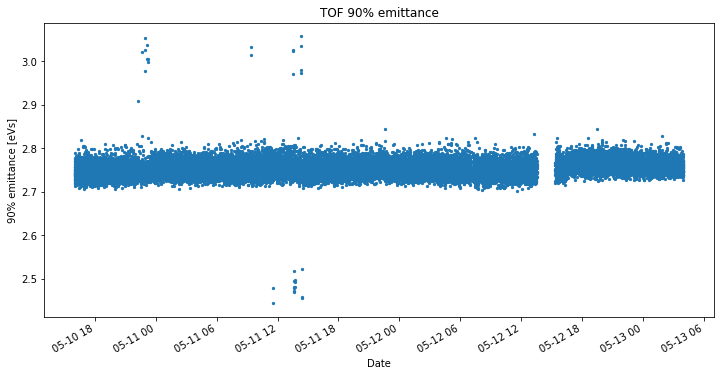

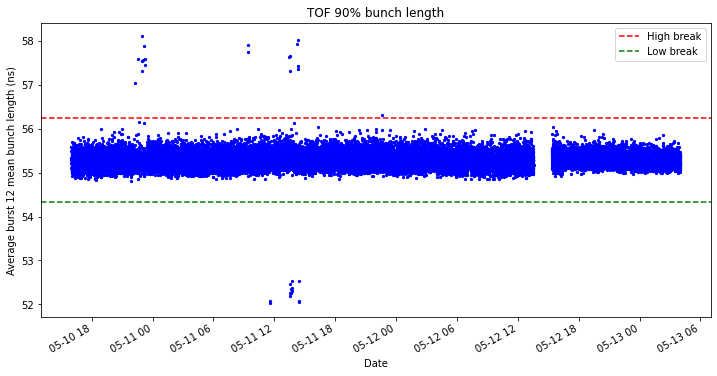

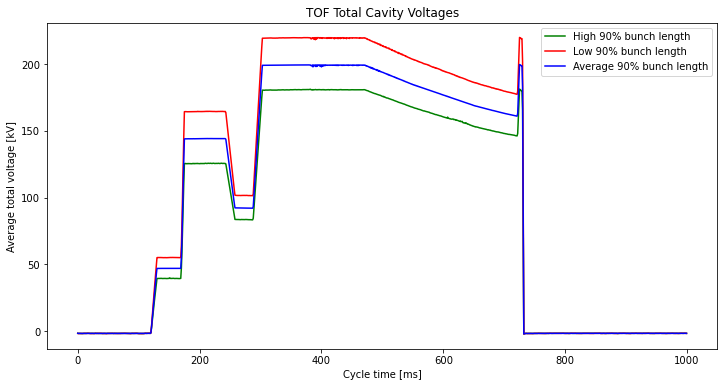

In [4]:
get_plots('TOF', '2025-05-10 16:00:00.000', '2025-05-13 04:00:00.000')

In [ ]:
start_time = '2025-05-10 16:00:00.000'
end_time = '2025-05-13 04:00:00.000'
user = 'TOF'


# 90% BUNCH LENGTH
    
# get data
df = ParameterDataQuery.builder(spark) \
    .system("CMW") \
    .parameterEq("PS.RING.PROC.BUNCH_PROFILES_BCW_OP/BunchLengthData") \
    .timeWindow(start_time, end_time) \
    .build()

# get correct user
df = filter_user(df, user, start_time, end_time)

# get rows into accessible format
df = df.withColumn("burstArray", df["burstId.elements"])
df = df.withColumn("bunchLengthArray", df["meanBunchLengthNs.elements"])

# find burst 12's average of mean bunch lengths
df = df.withColumn(
    "meanBunchLengthForBurst12",
    expr("""
        aggregate(
            filter(
                arrays_zip(burstArray, bunchLengthArray),
                x -> x.burstArray = 12
            ),
            0D,
            (acc, x) -> acc + x.bunchLengthArray
        ) / size(
            filter(
                arrays_zip(burstArray, bunchLengthArray),
                x -> x.burstArray = 12
            )
        )
    """)
)

# convert to pandas and cut out low values corresponding to no beam
data = df.select('cyclestamp','meanBunchLengthForBurst12').toPandas()
data = data.where(data['meanBunchLengthForBurst12'] > 2)

# record outliers' cyclestamps for voltage analysis
mu = data['meanBunchLengthForBurst12'].mean()
sigma = data['meanBunchLengthForBurst12'].std()
thresh = 5
data['z_score'] = (data['meanBunchLengthForBurst12'] - mu) / sigma
cyclestamps_high = set(data.loc[data['z_score'] > thresh, 'cyclestamp'].tolist())
cyclestamps_low = set(data.loc[data['z_score'] < -thresh, 'cyclestamp'].tolist())

# format date
data['cyclestamp'] = pd.to_datetime(data['cyclestamp'], utc=True)
data.set_index(data['cyclestamp'].dt.tz_convert(ZoneInfo("Europe/Berlin")), inplace=True, drop=True)
data.sort_index(inplace=True)

# plot
ax = data.plot.scatter(x='cyclestamp',y='meanBunchLengthForBurst12', s=5, color = 'blue')
plt.axhline((thresh*sigma+mu), linestyle = '--', label = 'High break', color='green')
plt.axhline((-thresh*sigma+mu), linestyle = '--', label = 'Low break', color= 'red')
plt.xlabel("Date")
plt.gcf().autofmt_xdate()
plt.ylabel("Average burst 12 mean bunch length (ns)")
plt.legend()
plt.title(user + " 90% bunch length")
plt.show()




In [5]:
# VOLTAGES


# get data for each cavity
vdc11 = ParameterDataQuery.builder(spark) \
    .system("CMW") \
    .parameterEq("PA.VDC11-SA/CycleSamples") \
    .timeWindow(start_time, end_time) \
    .build()
vdc36 = ParameterDataQuery.builder(spark) \
    .system("CMW") \
    .parameterEq("PA.VDC36-SA/CycleSamples") \
    .timeWindow(start_time, end_time) \
    .build()
vdc46 = ParameterDataQuery.builder(spark) \
    .system("CMW") \
    .parameterEq("PA.VDC46-SA/CycleSamples") \
    .timeWindow(start_time, end_time) \
    .build()
vdc51 = ParameterDataQuery.builder(spark) \
    .system("CMW") \
    .parameterEq("PA.VDC51-SA/CycleSamples") \
    .timeWindow(start_time, end_time) \
    .build()
vdc56 = ParameterDataQuery.builder(spark) \
    .system("CMW") \
    .parameterEq("PA.VDC56-SA/CycleSamples") \
    .timeWindow(start_time, end_time) \
    .build()
vdc66 = ParameterDataQuery.builder(spark) \
    .system("CMW") \
    .parameterEq("PA.VDC66-SA/CycleSamples") \
    .timeWindow(start_time, end_time) \
    .build()
vdc76 = ParameterDataQuery.builder(spark) \
    .system("CMW") \
    .parameterEq("PA.VDC76-SA/CycleSamples") \
    .timeWindow(start_time, end_time) \
    .build()
vdc81 = ParameterDataQuery.builder(spark) \
    .system("CMW") \
    .parameterEq("PA.VDC81-SA/CycleSamples") \
    .timeWindow(start_time, end_time) \
    .build()
vdc86 = ParameterDataQuery.builder(spark) \
    .system("CMW") \
    .parameterEq("PA.VDC86-SA/CycleSamples") \
    .timeWindow(start_time, end_time) \
    .build()
vdc91 = ParameterDataQuery.builder(spark) \
    .system("CMW") \
    .parameterEq("PA.VDC91-SA/CycleSamples") \
    .timeWindow(start_time, end_time) \
    .build()
vdc96 = ParameterDataQuery.builder(spark) \
    .system("CMW") \
    .parameterEq("PA.VDC96-SA/CycleSamples") \
    .timeWindow(start_time, end_time) \
    .build()


In [6]:
# put them in an array to make things easier
vdcs = [vdc11, vdc36, vdc46, vdc51, vdc56, vdc66, vdc76, vdc81, vdc86, vdc91, vdc96]

print(vdcs[0].count())

# get correct user and drop unneeded columns
vdcs = [filter_user(vdc, user, start_time, end_time).select('cyclestamp', 'samples') for vdc in vdcs]
print(vdcs[0].count())


137931
28172


In [7]:
# sort based on if 90% bunch length was high, average, or low
high_vdcs, low_vdcs, avg_vdcs = [], [], []
for vdc in vdcs:
    high, avg, low = split_vdc(vdc, cyclestamps_high, cyclestamps_low)
    high_vdcs.append(high)
    low_vdcs.append(low)
    avg_vdcs.append(avg)



In [8]:
# convert the high/low/avg arrays of dfs into a single df containing cyclestamps and a row type of the total voltage at each of the 1200 sampling times
high_total = total_vdc(high_vdcs)
low_total = total_vdc(low_vdcs)
avg_total = total_vdc(avg_vdcs)



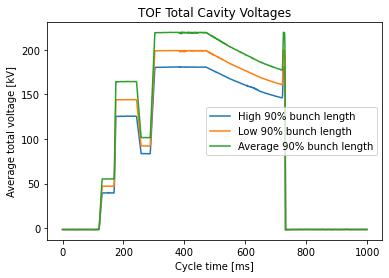

In [9]:
# get array of mean total voltage per group for each sampling instance
high_means = mean_vdc(high_total)
low_means = mean_vdc(low_total)
avg_means = mean_vdc(avg_total)

# plot
cycle_time = np.arange(start = 0, stop = 1200)
plt.plot(cycle_time, high_means, label = 'High 90% bunch length', color = 'green')
plt.plot(cycle_time, low_means, label = 'Low 90% bunch length', color 'red')
plt.plot(cycle_time, avg_means, label = 'Average 90% bunch length', color = 'blue')
plt.xlabel('Cycle time [ms]')
plt.ylabel('Average total voltage [kV]')
plt.title(user + ' Total Cavity Voltages')
plt.legend()
plt.show()

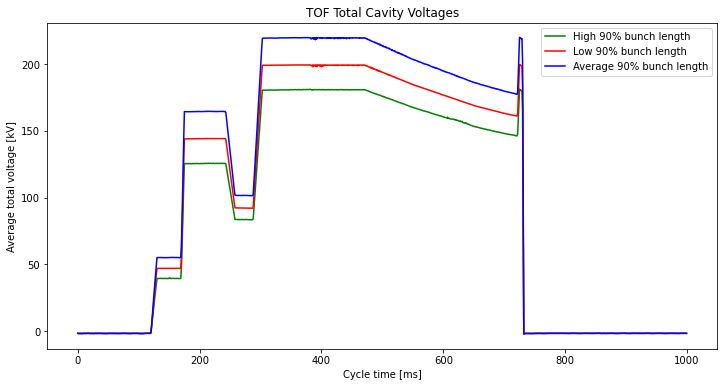

In [19]:
plt.figure(figsize=(12,6))
plt.plot(cycle_time, high_means, label = 'High 90% bunch length', color = 'green')
plt.plot(cycle_time, low_means, label = 'Low 90% bunch length', color = 'red')
plt.plot(cycle_time, avg_means, label = 'Average 90% bunch length', color = 'blue')
plt.xlabel('Cycle time [ms]')
plt.ylabel('Average total voltage [kV]')
plt.title(user + ' Total Cavity Voltages')
plt.legend()
plt.show()

In [3]:
from pyspark.sql import functions as F
from functools import reduce
import numpy as np

def get_plots_optimized(user, start_time, end_time):
    # Step 1: Fetch bunch length data + fundamental cyclestamps in ONE join
    bunch_df = ParameterDataQuery.builder(spark) \
        .system("CMW") \
        .parameterEq("PS.RING.PROC.BUNCH_PROFILES_BCW_OP/BunchLengthData") \
        .timeWindow(start_time, end_time) \
        .build()

    funds = DataQuery.builder(spark).byVariables() \
        .system('CMW') \
        .startTime(start_time).endTime(end_time) \
        .variable('CPS:NXCALS_FUNDAMENTAL') \
        .buildDataset() \
        .filter(F.col("USER") == user) \
        .select("cyclestamp")

    bunch_df = bunch_df.join(funds, on="cyclestamp", how="inner") \
        .withColumn("burstArray", F.col("burstId.elements")) \
        .withColumn("bunchLengthArray", F.col("meanBunchLengthNs.elements")) \
        .withColumn("meanBunchLengthForBurst12", F.expr("""
            aggregate(
                filter(arrays_zip(burstArray, bunchLengthArray), x -> x.burstArray = 12),
                0D,
                (acc, x) -> acc + x.bunchLengthArray
            ) / size(filter(arrays_zip(burstArray, bunchLengthArray), x -> x.burstArray = 12))
        """)) \
        .filter(F.col("meanBunchLengthForBurst12") > 2)

    bunch_pd = bunch_df.select("cyclestamp", "meanBunchLengthForBurst12").toPandas()
    mu, sigma = bunch_pd["meanBunchLengthForBurst12"].mean(), bunch_pd["meanBunchLengthForBurst12"].std()
    thresh = 5

    # Broadcast sets
    cyclestamps_high = set(bunch_pd[bunch_pd["meanBunchLengthForBurst12"] > mu + thresh * sigma]["cyclestamp"])
    cyclestamps_low = set(bunch_pd[bunch_pd["meanBunchLengthForBurst12"] < mu - thresh * sigma]["cyclestamp"])

    # Step 2: Fetch and join all VDCs into ONE DataFrame
    vdc_params = ["PA.VDC11-SA/CycleSamples", "PA.VDC36-SA/CycleSamples", "PA.VDC46-SA/CycleSamples",
                  "PA.VDC51-SA/CycleSamples", "PA.VDC56-SA/CycleSamples", "PA.VDC66-SA/CycleSamples",
                  "PA.VDC76-SA/CycleSamples", "PA.VDC81-SA/CycleSamples", "PA.VDC86-SA/CycleSamples",
                  "PA.VDC91-SA/CycleSamples", "PA.VDC96-SA/CycleSamples"]

    vdcs = [ParameterDataQuery.builder(spark).system("CMW").parameterEq(p).timeWindow(start_time, end_time).build() for p in vdc_params]
    vdcs = [df.join(funds, on="cyclestamp", how="inner").select("cyclestamp", F.col("samples.elements").alias(f"samples_{i}")) for i, df in enumerate(vdcs)]

    total_vdc = reduce(lambda left, right: left.join(right, on="cyclestamp"), vdcs)

    # Step 3: Precompute total_samples vector sum
    vec_cols = [f"samples_{i}" for i in range(len(vdc_params))]
    sum_expr = f"""
        transform(arrays_zip({','.join(vec_cols)}), x -> { ' + '.join(f'x.{col}' for col in vec_cols) })
    """
    total_vdc = total_vdc.withColumn("total_samples", F.expr(sum_expr))

    # Step 4: Single aggregation step
    def aggregate_group(df, cyclestamp_set):
        filtered = df.filter(F.col("cyclestamp").isin(cyclestamp_set))
        sum_count_expr = """
            aggregate(
                collect_list(total_samples),
                named_struct('sum', array_repeat(CAST(0.0 AS DOUBLE), 1200), 'count', 0),
                (acc, x) -> named_struct(
                    'sum', transform(arrays_zip(acc.sum, x), y -> y.sum + y.x),
                    'count', acc.count + 1)
            ) as acc
        """
        return filtered.selectExpr(sum_count_expr).selectExpr("transform(acc.sum, x -> x / acc.count) as mean").collect()[0]["mean"]

    high_means = np.array(aggregate_group(total_vdc, cyclestamps_high))
    low_means = np.array(aggregate_group(total_vdc, cyclestamps_low))
    avg_means = np.array(aggregate_group(total_vdc, set(bunch_pd["cyclestamp"]) - cyclestamps_high - cyclestamps_low))

    # Step 5: Plot
    cycle_time = np.arange(1200)
    plt.figure(figsize=(12,6))
    plt.plot(cycle_time, high_means, label='High', color='green')
    plt.plot(cycle_time, low_means, label='Low', color='red')
    plt.plot(cycle_time, avg_means, label='Average', color='blue')
    plt.xlabel('Cycle time [ms]')
    plt.ylabel('Total cavity voltage [kV]')
    plt.legend()
    plt.title(f"{user} Total Cavity Voltages")
    plt.show()

25/07/15 16:02:31 INFO ContextHandler: Started o.s.j.s.ServletContextHandler@22d17304{/SQL,null,AVAILABLE,@Spark}
25/07/15 16:02:31 INFO ContextHandler: Started o.s.j.s.ServletContextHandler@7a3951dd{/SQL/json,null,AVAILABLE,@Spark}
25/07/15 16:02:31 INFO ContextHandler: Started o.s.j.s.ServletContextHandler@11edbbd0{/SQL/execution,null,AVAILABLE,@Spark}
25/07/15 16:02:31 INFO ContextHandler: Started o.s.j.s.ServletContextHandler@226e95af{/SQL/execution/json,null,AVAILABLE,@Spark}
25/07/15 16:02:31 INFO ContextHandler: Started o.s.j.s.ServletContextHandler@48d72f57{/static/sql,null,AVAILABLE,@Spark}
25/07/15 16:02:41 WARN CheckAllocator: More than one DefaultAllocationManager on classpath. Choosing first found
25/07/15 16:06:40 WARN BlockManagerMasterEndpoint: No more replicas available for broadcast_59_piece0 !
25/07/15 16:06:40 WARN BlockManagerMaster: Failed to remove shuffle 6 - org.apache.spark.SparkException: Could not find BlockManagerEndpoint1.
	at org.apache.spark.rpc.netty.Di

25/07/15 16:21:03 WARN DAGScheduler: Broadcasting large task binary with size 14.6 MiB
25/07/15 16:21:38 WARN DAGScheduler: Broadcasting large task binary with size 14.5 MiB


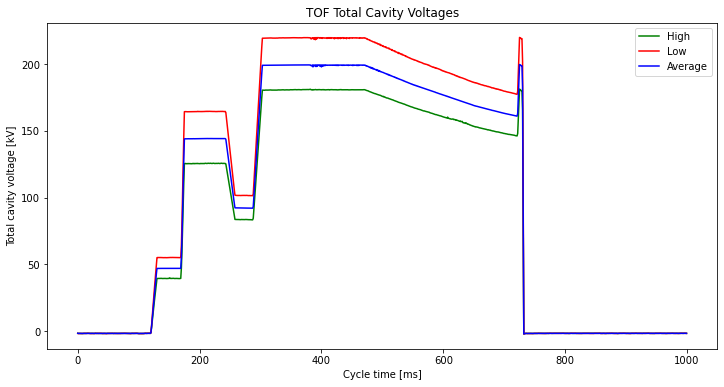

In [4]:
get_plots_optimized('TOF', '2025-05-10 16:00:00.000', '2025-05-13 04:00:00.000')